In [1]:
# !pip install -q --upgrade tqdm torch numpy #albumentations
# !apt -qq -y update && apt -qq -y upgrade

In [2]:
# ! pip install albumentations==0.4.6
# !pip install --upgrade --force-reinstall --no-deps albumentations

In [3]:
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# dataset_path = '/content/gdrive/MyDrive/MIS/styletransfer/pix2pix_dataset'
# Image.open('/content/gdrive/MyDrive/MIS/styletransfer/pix2pix_dataset/train/20.0_49.0_000.jpeg')

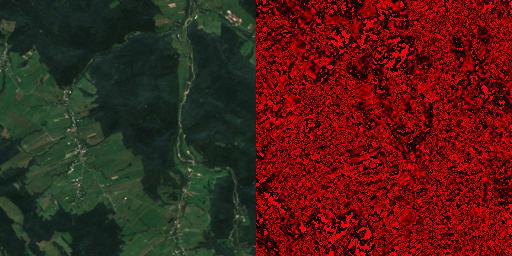

In [5]:
dataset_path = "C:/Users/supercomp/MapTransfer/dataset_vis2inf/dataset_pix2pix"
# example
Image.open(dataset_path+'/example/20.0_49.0_000.jpeg')

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = dataset_path + '/train'
VAL_DIR = dataset_path + '/valid'
TEST_DIR = dataset_path + '/test'
D_LEARNING_RATE = 1e-3
G_LEARNING_RATE = 1e-3
D_SCHEDULER_GAMMA = 1
G_SCHEDULER_GAMMA = 0.5
D_SCHEDULER_STEP = 80
G_SCHEDULER_STEP = 80
BATCH_SIZE = 64
NUM_WORKERS = 0
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = "disc.pth"
CHECKPOINT_GEN = "gen.pth"

both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        # A.HueSaturationValue(p=0.2),
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

In [7]:
def save_some_examples(gen, val_loader, epoch, folder, show_images=False):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    x1, y1 = next(iter(val_loader))
    x1, y1 = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    if not os.path.isdir(folder):
        os.makedirs(folder)

    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 1 + 0  # remove normalization#
        y1_fake = gen(x1)
        y1_fake = y1_fake * 1 + 0  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch:03d}.png")
        if epoch == 1:
            save_image(x * 1 + 0, folder + f"/input.png")
            save_image(y * 1 + 0, folder + f"/label.png")
    gen.train()
    
    if show_images:
        f, ax = plt.subplots(2,3, figsize=(10,10))
        x = x.squeeze().cpu().permute(1,2,0)
        y = y.squeeze().cpu().permute(1,2,0)
        y_fake = y_fake.squeeze().cpu().permute(1,2,0)
        x1 = x1.squeeze().cpu().permute(1,2,0)
        y1 = y1.squeeze().cpu().permute(1,2,0)
        y1_fake = y1_fake.squeeze().cpu().permute(1,2,0)

        ax[0].imshow(x)
        ax[1].imshow(y)
        ax[2].imshow(y_fake)
        ax[3].imshow(x1)
        ax[4].imshow(y1)
        ax[5].imshow(y1_fake)
        plt.show()


def plot_loss_lr(D_loss, G_loss, G_LR_plot, D_LR_plot):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    ax_lr = ax.twinx()
    ax.plot(D_loss, label='Discriminator loss (x10)')
    ax.plot(G_loss, label='Generator loss')
    ax_lr.plot(G_LR_plot, color='y', label='Generator LR', linewidth=0.5, alpha=0.7)
    ax_lr.plot(D_LR_plot, color='g', label='Discriminator LR', linewidth=0.5, alpha=0.7)

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax_lr.set_ylabel('Learning rate')
    
    ax.legend(loc=0)
    ax_lr.legend(loc=0, bbox_to_anchor=(1,0.9))
    plt.show()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [8]:
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, :256, :]
        target_image = image[:, 256:, :]

        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image


if __name__ == "__main__":
    dataset = MapDataset(TRAIN_DIR)
    loader = DataLoader(dataset, batch_size=5)
    for x, y in loader:
        print(x.shape)
        save_image(x, "x.png")
        save_image(y, "y.png")
        break

torch.Size([5, 3, 256, 256])


In [9]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)


if __name__ == "__main__":
    test()

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): Batc

In [10]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

torch.Size([1, 3, 256, 256])


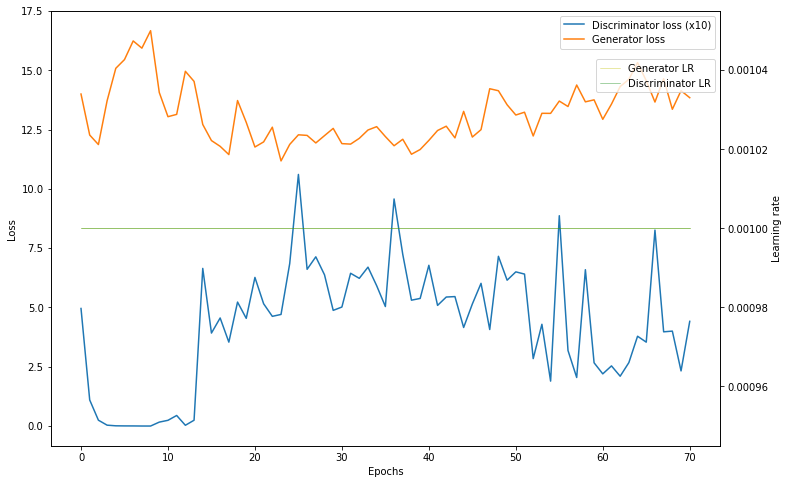

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


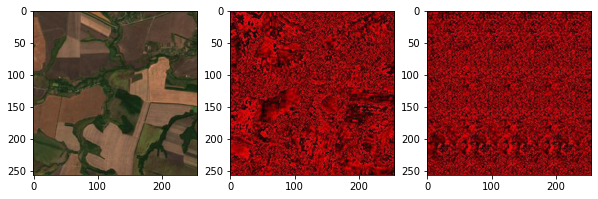

 99%|█████████▉| 192/193 [02:07<00:00,  1.40it/s, D_fake=0.0321, D_real=0.887, epoch=72]

In [11]:
%%time

def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler, epoch):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
                epoch=epoch+1
            )

    return D_loss, G_loss


def main():
    D_loss =  []
    G_loss = []
    D_LR_plot = []
    G_LR_plot = []
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=D_LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=G_LEARNING_RATE, betas=(0.5, 0.999))
    sheduler_disc = optim.lr_scheduler.StepLR(opt_disc, step_size=D_SCHEDULER_STEP, gamma=D_SCHEDULER_GAMMA)
    sheduler_gen = optim.lr_scheduler.StepLR(opt_gen, step_size=G_SCHEDULER_STEP, gamma=G_SCHEDULER_GAMMA)

    BCE = nn.BCEWithLogitsLoss()
    
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, G_LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, D_LEARNING_RATE,
        )

    train_dataset = MapDataset(root_dir=TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = MapDataset(root_dir=VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        if epoch != 0:  # to plot LR properly (scaler worksinside train func)
            sheduler_disc.step()
            sheduler_gen.step()

        D_loss_epoch, G_loss_epoch = train_fn(disc, gen, train_loader, opt_disc,
                                              opt_gen, L1_LOSS, BCE, g_scaler, d_scaler, epoch)

        
        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

        D_loss_epoch *= 10
        D_loss.append(D_loss_epoch.cpu().detach().numpy())
        G_loss.append(G_loss_epoch.cpu().detach().numpy())
        D_LR_plot.append(sheduler_disc.get_lr())
        G_LR_plot.append(sheduler_gen.get_lr())
        clear_output(True)
        plot_loss_lr(D_loss, G_loss, G_LR_plot, D_LR_plot)
        save_some_examples(gen, val_loader, epoch, folder="evaluation", show_images=True)


if __name__ == "__main__":
    main()